In [6]:
import torch
import torchvision
import timm
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model_names = timm.list_models('*vit*tiny*')
pprint(model_names)

['convit_tiny',
 'crossvit_tiny_240',
 'gcvit_tiny',
 'gcvit_xtiny',
 'gcvit_xxtiny',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxxvit_rmlp_tiny_rw_256',
 'mvitv2_tiny',
 'vit_tiny_patch16_224',
 'vit_tiny_patch16_224_in21k',
 'vit_tiny_patch16_384',
 'vit_tiny_r_s16_p8_224',
 'vit_tiny_r_s16_p8_224_in21k',
 'vit_tiny_r_s16_p8_384']


In [7]:
model = timm.create_model("vit_tiny_patch16_384", img_size=224,pretrained=True)
state_dict = model.state_dict()
num_heads = 3
model.blocks


Sequential(
  (0): Block(
    (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=192, out_features=576, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=192, out_features=192, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): Identity()
    (drop_path1): Identity()
    (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=192, out_features=768, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (fc2): Linear(in_features=768, out_features=192, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (ls2): Identity()
    (drop_path2): Identity()
  )
  (1): Block(
    (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=192, out_features=576, bias=True)
      (attn_drop): Dro

In [8]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [4]:
model.blocks[0]

Block(
  (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=192, out_features=576, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=192, out_features=192, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=768, out_features=192, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [34]:
W_qkv = state_dict["blocks.0.attn.qkv.weight"].t()  # Transpose to split correctly
# Splitting the combined matrix to get individual matrices for each head
W_q, W_k, _ = torch.chunk(W_qkv, 3, dim=1)  # Split along the column dimension
print(W_q.shape, W_k.shape)

torch.Size([192, 192]) torch.Size([192, 192])


In [39]:
W_q = W_q.T.view(192, 3, 192 // 3)
W_k = W_k.T.view(192, 3, 192 // 3)

In [29]:
print(W_q.shape, W_k.shape)

torch.Size([192, 3, 64]) torch.Size([192, 3, 64])


In [30]:
# W_q[:,0,0]

In [31]:
num_heads = 3
depth_per_head = 192 // num_heads  # 64 in this case

W_q_reshaped = W_q.view(num_heads, depth_per_head, -1)
W_k_reshaped = W_k.view(num_heads, depth_per_head, -1)

print(W_q_reshaped.shape)  # Should print torch.Size([3, 64, 192])
print(W_k_reshaped.shape)  # Should print torch.Size([3, 64, 192])


torch.Size([3, 64, 192])
torch.Size([3, 64, 192])


In [32]:
# W_q_reshaped[0,0,:]

In [33]:
W_q.permute(1, 2, 0) - W_q_reshaped


tensor([[[ 0.0000, -0.2423,  0.1616,  ...,  0.1625,  0.1615,  0.0319],
         [ 0.2423,  0.0000, -0.0266,  ..., -0.0046,  0.1170, -0.0062],
         [-0.1616,  0.0266,  0.0000,  ..., -0.0431, -0.0175,  0.1806],
         ...,
         [-0.1661,  0.0099,  0.0125,  ...,  0.2318,  0.0910,  0.1242],
         [-0.0566, -0.1509,  0.1117,  ..., -0.0524, -0.0016, -0.0936],
         [-0.0741,  0.0789,  0.0991,  ..., -0.1172, -0.0808, -0.2268]],

        [[-0.1259, -0.0308,  0.0965,  ...,  0.1022,  0.0462,  0.0126],
         [-0.0686,  0.0380,  0.0958,  ...,  0.1413,  0.0036, -0.0628],
         [-0.1042,  0.0262, -0.1088,  ...,  0.0294,  0.0064,  0.0151],
         ...,
         [-0.0659,  0.1451, -0.1677,  ..., -0.0196, -0.1307, -0.1426],
         [-0.1745,  0.0019,  0.0592,  ..., -0.0313,  0.0651,  0.0004],
         [-0.0388,  0.1013, -0.0390,  ..., -0.0976, -0.0135, -0.0509]],

        [[ 0.0361, -0.0042,  0.0470,  ..., -0.0415,  0.0363,  0.0968],
         [-0.1538, -0.1442, -0.1692,  ...,  0

In [35]:
W_q_zy = torch.stack(torch.chunk(W_q, 3, dim=0))
W_q_zy.shape

torch.Size([3, 64, 192])

In [41]:
W_q_zy - W_q.permute(1, 2, 0)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [37]:
# W_q_zy[0,0,:]

In [38]:
W_q_zy - W_q_reshaped

tensor([[[ 0.0000, -0.2423,  0.1616,  ...,  0.1625,  0.1615,  0.0319],
         [ 0.2423,  0.0000, -0.0266,  ..., -0.0046,  0.1170, -0.0062],
         [-0.1616,  0.0266,  0.0000,  ..., -0.0431, -0.0175,  0.1806],
         ...,
         [-0.1661,  0.0099,  0.0125,  ...,  0.2318,  0.0910,  0.1242],
         [-0.0566, -0.1509,  0.1117,  ..., -0.0524, -0.0016, -0.0936],
         [-0.0741,  0.0789,  0.0991,  ..., -0.1172, -0.0808, -0.2268]],

        [[-0.1259, -0.0308,  0.0965,  ...,  0.1022,  0.0462,  0.0126],
         [-0.0686,  0.0380,  0.0958,  ...,  0.1413,  0.0036, -0.0628],
         [-0.1042,  0.0262, -0.1088,  ...,  0.0294,  0.0064,  0.0151],
         ...,
         [-0.0659,  0.1451, -0.1677,  ..., -0.0196, -0.1307, -0.1426],
         [-0.1745,  0.0019,  0.0592,  ..., -0.0313,  0.0651,  0.0004],
         [-0.0388,  0.1013, -0.0390,  ..., -0.0976, -0.0135, -0.0509]],

        [[ 0.0361, -0.0042,  0.0470,  ..., -0.0415,  0.0363,  0.0968],
         [-0.1538, -0.1442, -0.1692,  ...,  0

In [167]:
# def forward_hook(module, input, output):
#     print("Output shape:", output.shape)
#     # Optionally, store the output if you want
#     # outputs.append(output)

# model.blocks[0].norm1.register_forward_hook(forward_hook)
# # Repeat for other blocks if needed

# # Now, when you run a forward pass through the model, you'll get the printout of the desired intermediate shape.
# # input_tensor = torch.rand(64, 3, 224, 224)
# # model(input_tensor)


In [168]:
# List to save outputs
intermediate_outputs = []

# Hook function
def pre_forward_hook(module, input):
    intermediate_outputs.append(input[0].clone())

# Register the pre-forward hook with attention layers in all blocks
for block in model.blocks:
    block.attn.register_forward_pre_hook(pre_forward_hook)

In [ ]:
# Now run your model with some data
input_tensor = torch.rand(64, 3, 224, 224)
model(input_tensor)

# The intermediate_outputs list should now contain the outputs before each attention layer
print(len(intermediate_outputs))  # Number of blocks with attention layers
print(intermediate_outputs[0].shape)  # Should be [64, 196, 192] or similar


In [5]:
for i,val in enumerate(intermediate_outputs):
    print(intermediate_outputs[i].shape)

torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])


## datasets

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
statistics = {'mean': [0.4914, 0.4822, 0.4465], 
            'std':  [0.247, 0.243, 0.261]}
img_size = 224
root = '/Users/zyxu/Documents/py/datasets'

In [7]:
trainset = torchvision.datasets.CIFAR10(root='/Users/zyxu/Documents/py/datasets', train=True,
                                        download=True, 
                                        transform=transforms.Compose([
                                            transforms.Resize((img_size, img_size)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**statistics)
                                        ]))

Files already downloaded and verified


In [8]:
trainset[0][0].shape

torch.Size([3, 224, 224])

In [59]:
# Compute the mean and standard deviation of the dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
iterator = iter(trainloader)

In [62]:
data = next(iterator)

In [63]:
data

[tensor([[[[-0.9575, -0.9575, -0.9575,  ..., -0.3700, -0.3700, -0.3700],
           [-0.9575, -0.9575, -0.9575,  ..., -0.3700, -0.3700, -0.3700],
           [-0.9575, -0.9575, -0.9575,  ..., -0.3700, -0.3700, -0.3700],
           ...,
           [-0.4812, -0.4812, -0.4812,  ..., -0.6558, -0.6558, -0.6558],
           [-0.4812, -0.4812, -0.4812,  ..., -0.6558, -0.6558, -0.6558],
           [-0.4812, -0.4812, -0.4812,  ..., -0.6558, -0.6558, -0.6558]],
 
          [[-1.5164, -1.5164, -1.5164,  ..., -0.6772, -0.6772, -0.6772],
           [-1.5164, -1.5164, -1.5164,  ..., -0.6772, -0.6772, -0.6772],
           [-1.5164, -1.5164, -1.5164,  ..., -0.6772, -0.6772, -0.6772],
           ...,
           [-0.6288, -0.6288, -0.6288,  ..., -0.7256, -0.7256, -0.7256],
           [-0.6288, -0.6288, -0.6288,  ..., -0.7256, -0.7256, -0.7256],
           [-0.6288, -0.6288, -0.6288,  ..., -0.7256, -0.7256, -0.7256]],
 
          [[-1.2750, -1.2750, -1.2750,  ..., -0.5989, -0.5989, -0.5989],
           [-

In [64]:
data[0].shape

torch.Size([64, 3, 224, 224])

In [172]:
intermediate_outputs = []
out = model(data[0])

In [130]:
out.shape

torch.Size([64, 1000])

In [131]:
print(len(intermediate_outputs))
for i,val in enumerate(intermediate_outputs):
    print(intermediate_outputs[i].shape)

0


# attention map

In [24]:
import matplotlib.pyplot as plt

def visualize_matrix(matrix, title=""):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(matrix, cmap='viridis')
    plt.colorbar()
    plt.show()

## layer 0

In [17]:
W_qkv = state_dict["blocks.0.attn.qkv.weight"].t()  # Transpose to split correctly
# Splitting the combined matrix to get individual matrices for each head
W_q, W_k, W_v = torch.chunk(W_qkv, 3, dim=1)  # Split along the column dimension

# Since there are 3 heads, we further split each matrix along the row dimension
W_qs = torch.chunk(W_q, 3, dim=0)
W_ks = torch.chunk(W_k, 3, dim=0)
W_vs = torch.chunk(W_v, 3, dim=0)

W_proj = state_dict["blocks.0.attn.proj.weight"]
# Split W_proj along its column dimension
W_projs = torch.chunk(W_proj, 3, dim=0)

In [20]:
print(W_q.shape, W_k.shape, W_v.shape)
print(W_qs[0].shape)
print(W_projs[0].shape)

torch.Size([192, 192]) torch.Size([192, 192]) torch.Size([192, 192])
torch.Size([64, 192])
torch.Size([64, 192])


In [21]:
X = intermediate_outputs[0]
X.shape

torch.Size([64, 197, 192])

In [26]:
x = X[0]
x.shape

torch.Size([197, 192])

#### 1 head

In [31]:
W_qi = W_qs[0].t()
print("W_qi shape", W_qi.shape)
W_ki = W_ks[0].t()
print("W_ki shape", W_ki.shape)
scores = (X @ W_qi @ W_ki.t() @ X.transpose(-2,-1)) / np.sqrt(64) 

W_qi shape torch.Size([192, 64])
W_ki shape torch.Size([192, 64])


In [32]:
scores.shape

torch.Size([64, 197, 197])

In [42]:
F.softmax(scores, dim = -1).mean(0)

tensor([[0.0108, 0.0049, 0.0044,  ..., 0.0059, 0.0055, 0.0066],
        [0.0024, 0.0251, 0.0117,  ..., 0.0040, 0.0038, 0.0037],
        [0.0021, 0.0117, 0.0271,  ..., 0.0042, 0.0049, 0.0042],
        ...,
        [0.0028, 0.0044, 0.0043,  ..., 0.0201, 0.0108, 0.0085],
        [0.0025, 0.0040, 0.0049,  ..., 0.0111, 0.0232, 0.0106],
        [0.0033, 0.0041, 0.0046,  ..., 0.0090, 0.0111, 0.0200]],
       grad_fn=<MeanBackward1>)

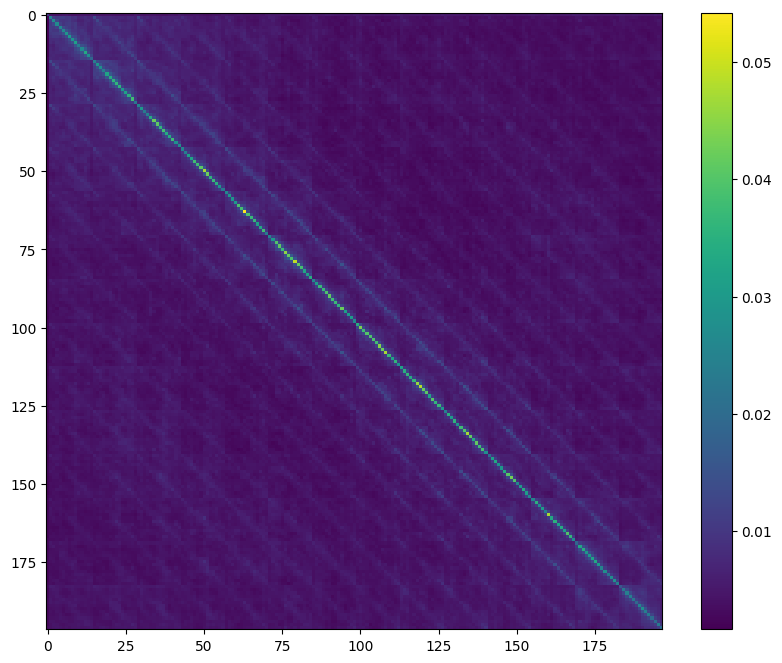

In [45]:
visualize_matrix(F.softmax(scores, dim = -1).mean(0).detach().numpy())

#### average over 3 heads

In [20]:
X = intermediate_outputs[0]
X.shape

torch.Size([64, 197, 192])

In [48]:
# For storing attention maps for each head
attention_maps = []

for i in range(3):  # For each head
    W_qi, W_ki = W_qs[i].t(), W_ks[i].t()
    
    # Compute the attention score using the provided formula
    scores = (X @ W_qi @ W_ki.t() @ X.transpose(-2, -1)) / np.sqrt(64)  # Assuming k = 64
    
    # Apply softmax to get the attention map for this head
    attention_map = F.softmax(scores, dim=-1)
    
    attention_maps.append(attention_map)

# Average over the heads and then average over the batch
avg_attention_map = torch.stack(attention_maps).mean(0).mean(0)


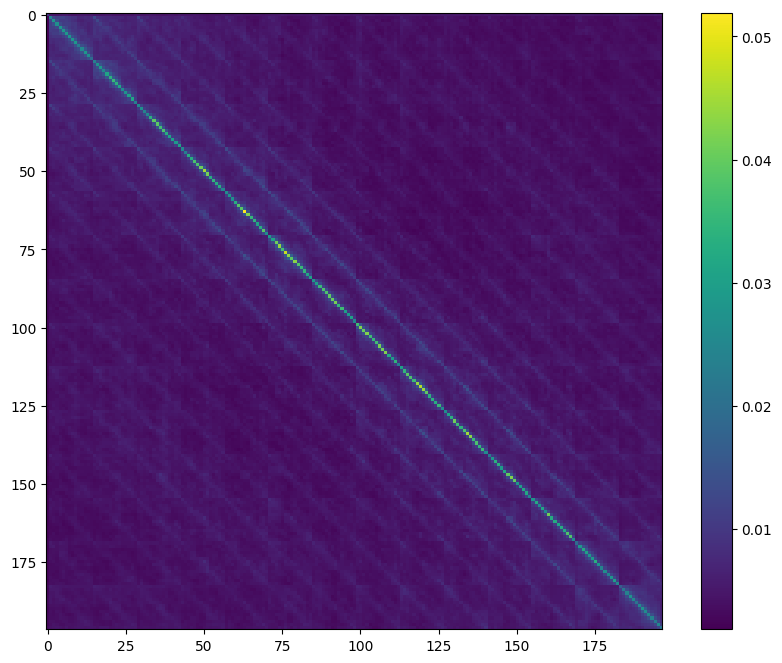

In [50]:
visualize_matrix(avg_attention_map.detach().numpy())

## Side by side through layers

In [181]:
import matplotlib.pyplot as plt
import numpy as np

### 3 figure in one row, 1 row in total
# def visualize_matrices_side_by_side(matrices, titles):
#     fig, axes = plt.subplots(1, len(matrices), figsize=(15, 5))
#     for ax, matrix, title in zip(axes, matrices, titles):
#         ax.imshow(matrix, cmap='viridis')
#         ax.set_title(title)
#         ax.axis('off')
#     plt.colorbar(axes[-1].imshow(matrices[-1], cmap='viridis'), ax=axes.ravel().tolist())
#     plt.show()



In [182]:
num_blocks = 12
num_heads = 3
# Initialize containers for all blocks' weights
W_q_all, W_k_all, W_v_all, W_proj_all = [], [], [], []

for block_idx in range(num_blocks):
    prefix = f"blocks.{block_idx}.attn."

    W_qkv = state_dict[prefix + "qkv.weight"].t()  # Transpose for splitting
    W_q, W_k, W_v = torch.chunk(W_qkv, 3, dim=1)
    W_q_all.append(torch.chunk(W_q, num_heads, dim=0)) # each item is W_qs before in one layer
    W_k_all.append(torch.chunk(W_k, num_heads, dim=0))
    W_v_all.append(torch.chunk(W_v, num_heads, dim=0))
    W_proj_all.append(torch.chunk(state_dict[prefix + "proj.weight"], num_heads, dim=0))

In [183]:
layer_id = 0
W_qs = W_q_all[layer_id]
W_ks = W_k_all[layer_id]
X = intermediate_outputs[layer_id]
X.shape

torch.Size([64, 197, 192])

In [184]:
def compute_avg_head_att_map_per_layer(X, W_qs, W_ks):
    # For storing attention maps for each head
    attention_maps = []

    for i in range(3):  # For each head
        W_qi, W_ki = W_qs[i].t(), W_ks[i].t()
        
        # Compute the attention score using the provided formula
        scores = (X @ W_qi @ W_ki.t() @ X.transpose(-2, -1)) / np.sqrt(64)  # Assuming k = 64
        
        # Apply softmax to get the attention map for this head
        attention_map = F.softmax(scores, dim=-1)
        
        attention_maps.append(attention_map)

    # Average over the heads and then average over the batch
    avg_attention_map = torch.stack(attention_maps).mean(0).mean(0)
    return avg_attention_map

In [185]:
avg_attention_map = compute_avg_head_att_map_per_layer(X, W_qs, W_ks)

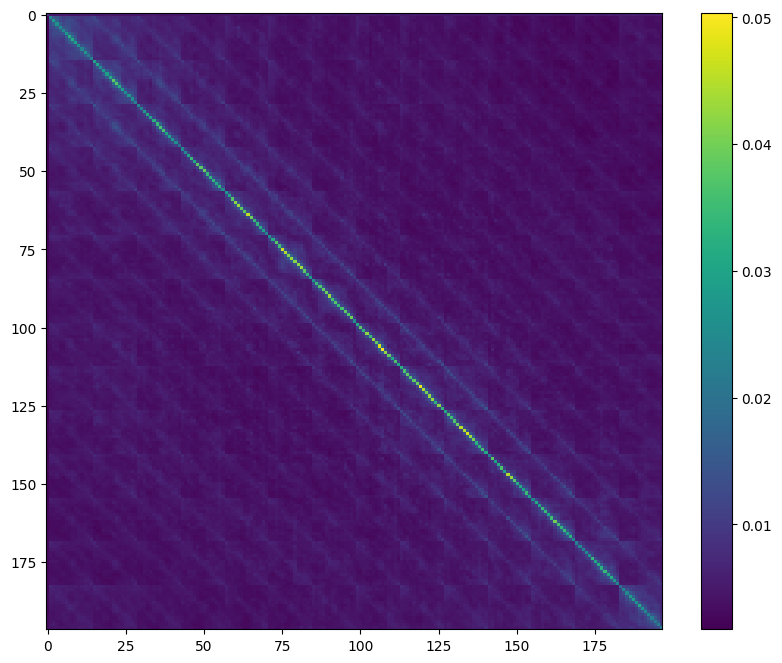

In [186]:
visualize_matrix(avg_attention_map.detach().numpy())

In [187]:
### To display 12 figures (4 figures per row, for a total of 3 rows)
def visualize_matrices_side_by_side(matrices, titles):
    if len(matrices) != 12 or len(titles) != 12:
        raise ValueError("This function expects 12 matrices and 12 titles!")

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))

    for i in range(3):
        for j in range(4):
            ax = axes[i, j]
            index = i*4 + j
            matrix = matrices[index]
            title = titles[index]
            
            ax.imshow(matrix, cmap='viridis')
            ax.set_title(title)
            ax.axis('off')

    # Adding colorbar using the last subplot
    fig.colorbar(axes[-1, -1].imshow(matrices[-1], cmap='viridis'), ax=axes.ravel().tolist())
    plt.tight_layout(pad = 2.0)
    plt.show()

In [188]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def visualize_matrices_side_by_side(matrices, titles):
    if len(matrices) != 12 or len(titles) != 12:
        raise ValueError("This function expects 12 matrices and 12 titles!")

    fig = plt.figure(figsize=(18, 12))

    # Create a gridspec to allocate space for the colorbar
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1, 0.05])

    ax_list = []
    for i in range(3):
        for j in range(4):
            ax_list.append(plt.subplot(gs[i, j]))

    for ax, matrix, title in zip(ax_list, matrices, titles):
        cax = ax.imshow(matrix, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')

    # Adding colorbar using the space allocated by the gridspec
    cbar_ax = plt.subplot(gs[:, 4])
    fig.colorbar(cax, cax=cbar_ax)

    plt.tight_layout()
    plt.savefig("pre.pdf", format="pdf", bbox_inches='tight')
    plt.show()


In [189]:
atten_maps = []
for layer_id in range(12):
    W_qs = W_q_all[layer_id]
    W_ks = W_k_all[layer_id]
    X = intermediate_outputs[layer_id]
    avg_attention_map = compute_avg_head_att_map_per_layer(X, W_qs, W_ks).detach().numpy() 
    atten_maps.append(avg_attention_map) 

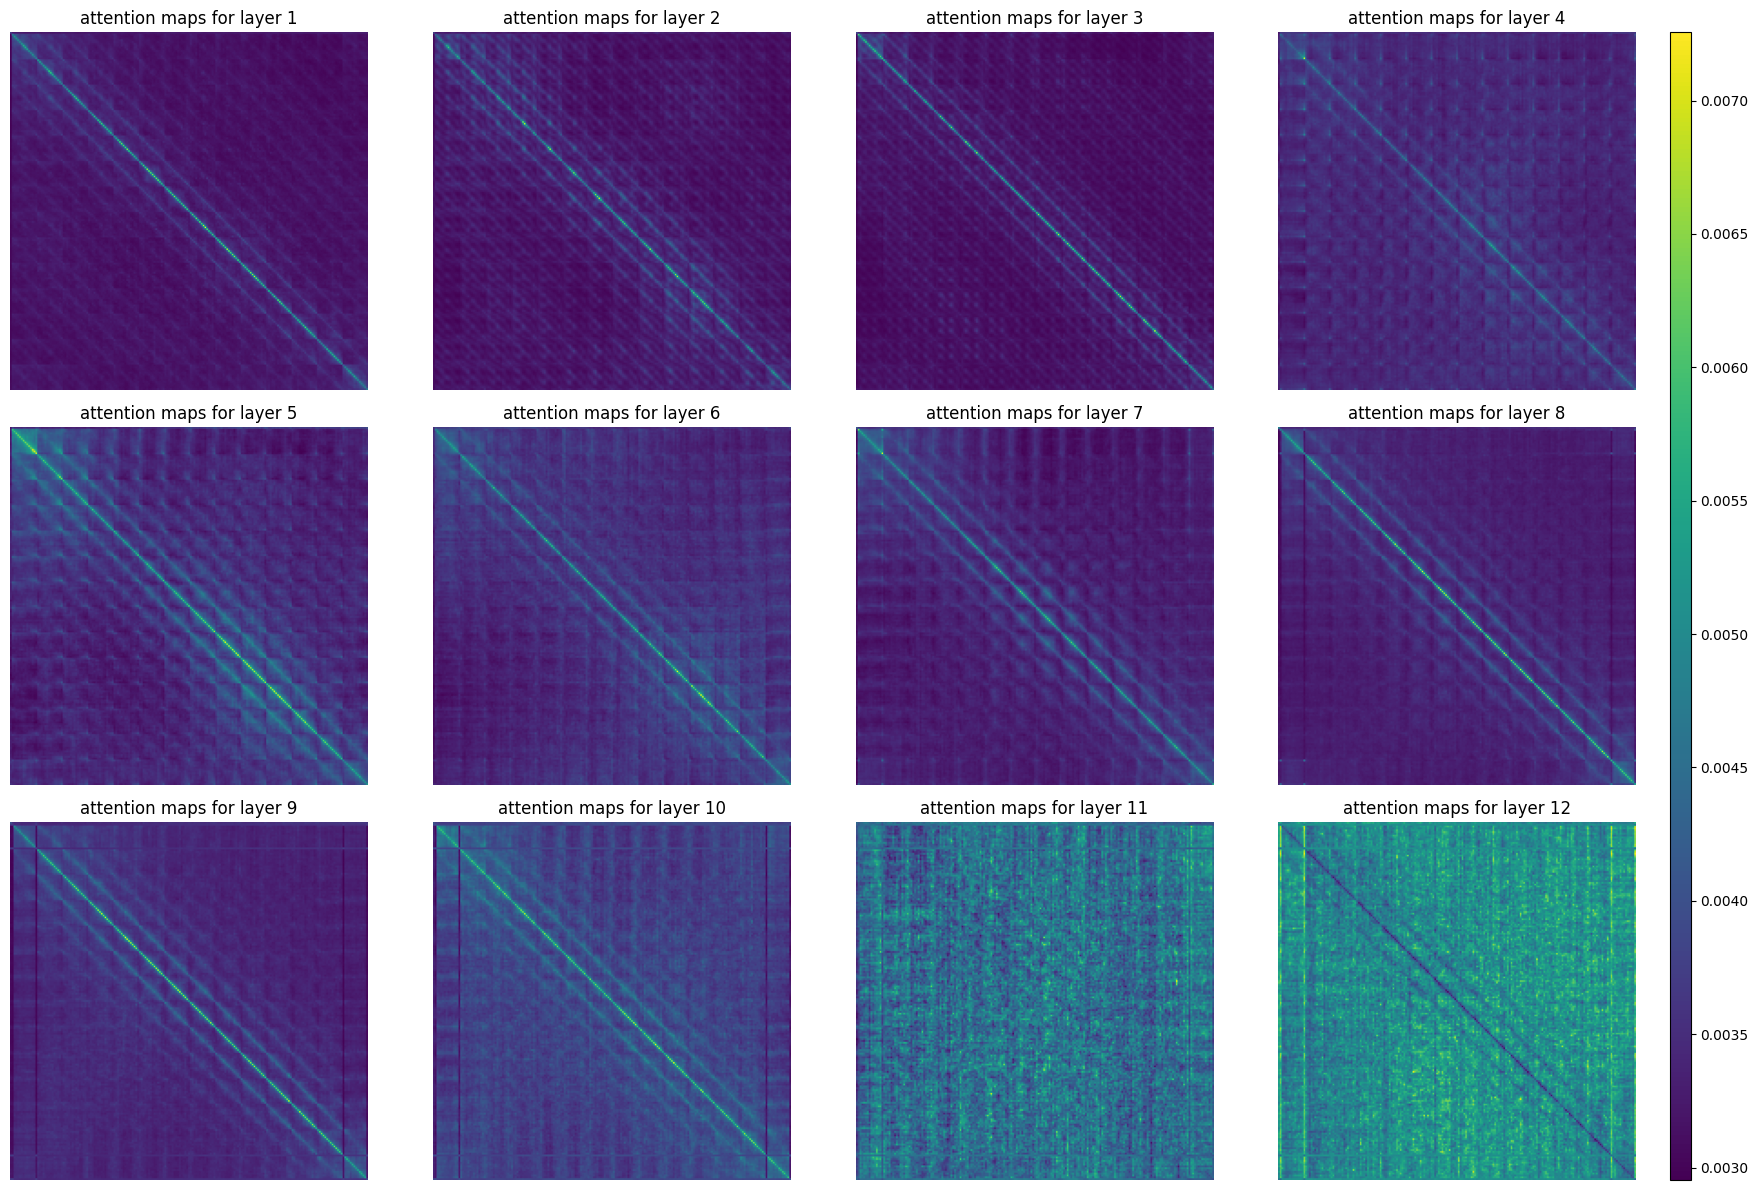

In [190]:
visualize_matrices_side_by_side(atten_maps, [f"attention maps for layer {i+1}" for i in range(12)])
